# Exploratory Data Analysis

In [2]:
#import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, date, timedelta
from pandas import DataFrame
import requests
import json
import random

In [13]:
#Download data set for explore a case count
url = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
data = pd.read_csv(url,
				 encoding= 'utf8', 
				 usecols=['Bundesland', 'AnzahlFall', 'Meldedatum'],
				 parse_dates=['Meldedatum'])

bundesland_cases = data.groupby(['Bundesland', 'Meldedatum'], as_index = False)['AnzahlFall'].sum()
bundesland_cases = bundesland_cases.set_index("Meldedatum").sort_index()
print(bundesland_cases)    

                        Bundesland  AnzahlFall
Meldedatum                                    
2020-01-02     Nordrhein-Westfalen           1
2020-01-03       Baden-Württemberg           1
2020-01-12     Nordrhein-Westfalen           1
2020-01-18             Brandenburg           1
2020-01-28     Nordrhein-Westfalen           1
2020-01-28                  Bayern           2
2020-01-29                  Bayern           2
2020-01-30     Nordrhein-Westfalen           1
2020-01-31                  Bayern           5
2020-01-31                Saarland           1
2020-02-03                  Bayern           1
2020-02-04                  Bayern           3
2020-02-04           Niedersachsen           1
2020-02-06                  Bayern           1
2020-02-07                  Bayern           1
2020-02-11                  Bayern           2
2020-02-12     Nordrhein-Westfalen           1
2020-02-12                  Bayern           1
2020-02-20     Nordrhein-Westfalen           1
2020-02-24   

                Bundesland  AnzahlFall
0        Baden-Württemberg      174883
1                   Bayern      243736
2                   Berlin       74532
3              Brandenburg       23890
4                   Bremen       11182
5                  Hamburg       27690
6                   Hessen      100880
7   Mecklenburg-Vorpommern        7350
8            Niedersachsen       80869
9      Nordrhein-Westfalen      298403
10         Rheinland-Pfalz       52136
11                Saarland       14643
12                 Sachsen       75871
13          Sachsen-Anhalt       16437
14      Schleswig-Holstein       16565
15               Thüringen       22854


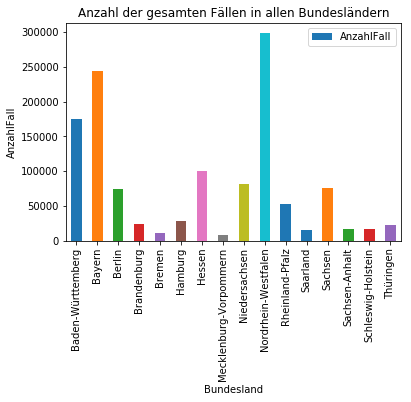

In [35]:
# accumulate cases per Bundesland

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()
print(bundesland_cases_sum)
bundesland_cases_sum.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Folgende Schritte werden analysiert:
- Wir haben festgestellt, dass die meisten Cases in folgenden Bundesländer vorkommen:
  Baden-Württemberg, Bayern, Berlin, Hessen, Neidersachsen, NRW, Rheinland-Pfalz und Sachsen. Diese würden wir   ein bisschen genauer anschauen, um festzustellen, welche Maßnahmen dort eingeführt waren
- Und umgekehrt wollen wir die Bunderländer betrachten, die nicht so viele Anzahl der Fällen enthalten, welche Maßnahmen sind dort eingeführt
- Vergleichen die beiden Ergebnisse -> Abhängigkeiten herausfinden?



                Bundesland  AnzahlFall
3              Brandenburg     23890.0
4                   Bremen     11182.0
5                  Hamburg     27690.0
7   Mecklenburg-Vorpommern      7350.0
11                Saarland     14643.0
13          Sachsen-Anhalt     16437.0
14      Schleswig-Holstein     16565.0
15               Thüringen     22854.0


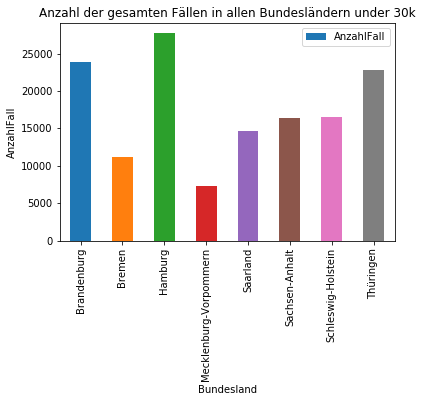

In [37]:
# making filter series for under 30k cases
filter = bundesland_cases_sum["AnzahlFall"]<30000
  
# filtering data on basis of both filters 
bundesland_cases_sum_under_30k = bundesland_cases_sum.where(filter).dropna()

print(bundesland_cases_sum_under_30k)
bundesland_cases_sum_under_30k.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern under 30k')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

In [56]:
#download data for restriction measures
country="Germany"
url="https://raw.githubusercontent.com/saudiwin/corona_tscs/master/data/CoronaNet/data_country/coronanet_release/coronanet_release_{0}.csv".format(country)
restriction_data=pd.read_csv(url, encoding='iso-8859-1')

In [64]:
#print(restriction_data)

restriction_data['target_province'] = restriction_data['target_province'].str.replace(';','')
restriction_data['target_province'] = restriction_data['target_province'].str.replace(r'^-$','Countrywide')
restriction_data[(data.target_province.isin(['-', np.nan]))] = restriction_data[(restriction_data.target_province.isin(['-', np.nan]))].assign(target_province = 'Countrywide')
           

filter=restriction_data["target_province"].str.contains('Berlin')
restriction_data_for_berlin = restriction_data.where(filter)#.dropna()

print(restriction_data_for_berlin)


      Unnamed: 0            record_id  policy_id entry_type correct_type  \
0            NaN                  NaN        NaN        NaN          NaN   
1            NaN                  NaN        NaN        NaN          NaN   
2            NaN                  NaN        NaN        NaN          NaN   
3            NaN                  NaN        NaN        NaN          NaN   
4            NaN                  NaN        NaN        NaN          NaN   
5            NaN                  NaN        NaN        NaN          NaN   
6            NaN                  NaN        NaN        NaN          NaN   
7            NaN                  NaN        NaN        NaN          NaN   
8            NaN                  NaN        NaN        NaN          NaN   
9            NaN                  NaN        NaN        NaN          NaN   
10           NaN                  NaN        NaN        NaN          NaN   
11           NaN                  NaN        NaN        NaN          NaN   
12          